Training Fractal Model...
Baseline Accuracy: 0.1817
Calculating Thermodynamic Map...
Running Pruning Test...
Sparsity 0.10 | Mag: 0.1814 | Therm: 0.1766
Sparsity 0.20 | Mag: 0.1761 | Therm: 0.1589
Sparsity 0.30 | Mag: 0.1634 | Therm: 0.1505
Sparsity 0.40 | Mag: 0.1467 | Therm: 0.1322
Sparsity 0.50 | Mag: 0.1278 | Therm: 0.1192
Sparsity 0.59 | Mag: 0.0911 | Therm: 0.1053
Sparsity 0.69 | Mag: 0.0670 | Therm: 0.0941
Sparsity 0.79 | Mag: 0.0233 | Therm: 0.0808
Sparsity 0.89 | Mag: 0.0225 | Therm: 0.0573
Sparsity 0.99 | Mag: 0.0284 | Therm: 0.0231


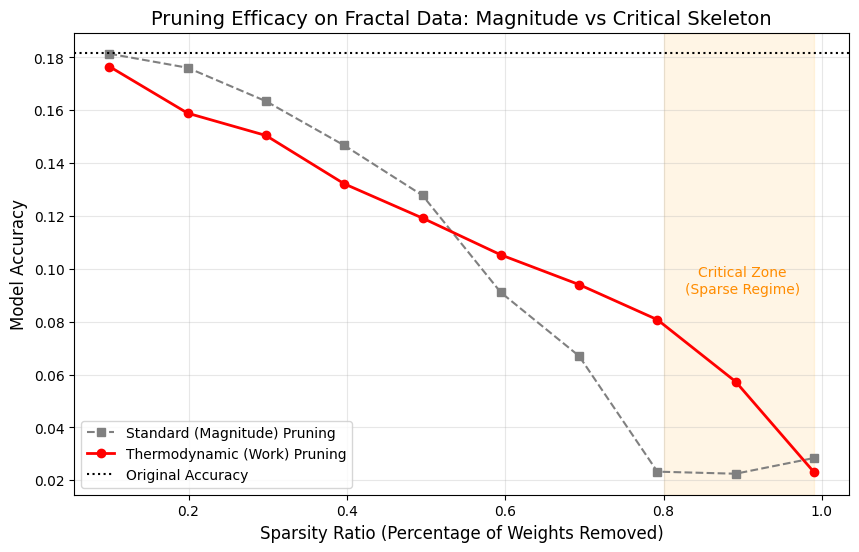

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune
from copy import deepcopy

# ==========================================
# 1. 配置
# ==========================================
VOCAB_SIZE = 1000
SEQ_LEN = 64
EMBED_DIM = 64
NUM_HEADS = 1
TRAIN_STEPS = 2000
PRUNING_RATIOS = np.linspace(0.1, 0.99, 10) # 从剪掉10%到剪掉99%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 2. 数据与模型 (复用之前的分形配置)
# ==========================================
def generate_fractal_data(num_samples, seq_len, vocab_size):
    data = torch.randint(0, vocab_size, (num_samples, seq_len), dtype=torch.long)
    ranks = np.arange(1, vocab_size + 1)
    probs = 1.0 / ranks
    probs /= probs.sum()
    for i in range(num_samples):
        topic_token = np.random.choice(vocab_size, p=probs)
        idx = np.random.choice(seq_len, int(seq_len * 0.2), replace=False)
        data[i, idx] = topic_token
    return data

class CausalTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        self.pos_embedding = nn.Parameter(torch.randn(1, SEQ_LEN, EMBED_DIM) * 0.02)
        # 使用 Linear 层模拟 Attention 的投影矩阵以便于剪枝
        self.W_q = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.W_k = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.W_v = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.W_o = nn.Linear(EMBED_DIM, EMBED_DIM)
        self.fc = nn.Linear(EMBED_DIM, VOCAB_SIZE)

        self.input_scale = 2.0
        mask = torch.triu(torch.ones(SEQ_LEN, SEQ_LEN) * float('-inf'), diagonal=1)
        self.register_buffer("mask", mask)

    def forward(self, x):
        B, T = x.shape
        emb = (self.embedding(x) + self.pos_embedding[:, :T, :]) * self.input_scale

        # Self-Attention Logic
        Q = self.W_q(emb)
        K = self.W_k(emb)
        V = self.W_v(emb)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(EMBED_DIM)
        scores = scores.masked_fill(self.mask[:T, :T] == float('-inf'), float('-inf'))
        attn_weights = torch.softmax(scores, dim=-1)

        attn_out = torch.matmul(attn_weights, V)
        out = self.W_o(attn_out)

        logits = self.fc(out)
        return logits

# ==========================================
# 3. 剪枝算法实现
# ==========================================

def calculate_accuracy(model, inputs, targets):
    with torch.no_grad():
        logits = model(inputs)
        preds = torch.argmax(logits, dim=-1)
        correct = (preds == targets).sum().item()
        return correct / targets.numel()

def get_thermodynamic_scores(model, inputs, targets):
    """
    计算热力学分数: Energy = |weight * gradient|
    这代表了参数对系统的'做功'大小。
    """
    model.zero_grad()
    logits = model(inputs)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
    loss.backward()

    scores = {}
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # Work = |w * dL/dw|
            work = torch.abs(module.weight.data * module.weight.grad)
            scores[name] = work
    return scores

def prune_model(model, ratio, method='magnitude', thermo_scores=None):
    """
    执行剪枝。
    method='magnitude': 传统的 L1 剪枝
    method='thermodynamic': 我们的物理剪枝
    """
    # 复制模型以免破坏原件
    pruned_model = deepcopy(model)

    # 收集所有权重展平，确定全局阈值
    all_scores = []
    modules = []

    for name, module in pruned_model.named_modules():
        if isinstance(module, nn.Linear):
            modules.append(module)
            if method == 'magnitude':
                score = torch.abs(module.weight.data)
            elif method == 'thermodynamic':
                score = thermo_scores[name]
            all_scores.append(score.flatten())

    all_scores = torch.cat(all_scores)
    # 找到第 k% 小的值作为阈值
    k = int(len(all_scores) * ratio)
    threshold = torch.topk(all_scores, k, largest=False).values.max()

    # 执行剪枝 (Masking)
    for name, module in pruned_model.named_modules():
        if isinstance(module, nn.Linear):
            if method == 'magnitude':
                mask = torch.abs(module.weight.data) > threshold
            elif method == 'thermodynamic':
                mask = thermo_scores[name] > threshold

            # Apply mask
            prune.custom_from_mask(module, name='weight', mask=mask)

    return pruned_model

# ==========================================
# 4. 实验流程
# ==========================================

# A. 训练一个好模型 (Hub 结构已形成)
print("Training Fractal Model...")
train_data = generate_fractal_data(1000, SEQ_LEN+1, VOCAB_SIZE)
inputs = train_data[:, :-1].to(device)
targets = train_data[:, 1:].to(device)

model = CausalTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

for step in range(TRAIN_STEPS):
    idx = torch.randint(0, len(inputs), (32,))
    optimizer.zero_grad()
    logits = model(inputs[idx])
    loss = criterion(logits.reshape(-1, VOCAB_SIZE), targets[idx].reshape(-1))
    loss.backward()
    optimizer.step()

base_acc = calculate_accuracy(model, inputs[:100], targets[:100])
print(f"Baseline Accuracy: {base_acc:.4f}")

# B. 计算热力学分数 (只算一次，作为特征图谱)
print("Calculating Thermodynamic Map...")
thermo_scores = get_thermodynamic_scores(model, inputs[:32], targets[:32])

# C. 对比剪枝测试
acc_mag = []
acc_therm = []

print("Running Pruning Test...")
for ratio in PRUNING_RATIOS:
    # 1. Magnitude Pruning
    p_m = prune_model(model, ratio, method='magnitude')
    acc_m = calculate_accuracy(p_m, inputs[:100], targets[:100])
    acc_mag.append(acc_m)

    # 2. Thermodynamic Pruning
    p_t = prune_model(model, ratio, method='thermodynamic', thermo_scores=thermo_scores)
    acc_t = calculate_accuracy(p_t, inputs[:100], targets[:100])
    acc_therm.append(acc_t)

    print(f"Sparsity {ratio:.2f} | Mag: {acc_m:.4f} | Therm: {acc_t:.4f}")

# ==========================================
# 5. 可视化
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(PRUNING_RATIOS, acc_mag, 's--', color='gray', label='Standard (Magnitude) Pruning')
plt.plot(PRUNING_RATIOS, acc_therm, 'o-', color='red', linewidth=2, label='Thermodynamic (Work) Pruning')

plt.title("Pruning Efficacy on Fractal Data: Magnitude vs Critical Skeleton", fontsize=14)
plt.xlabel("Sparsity Ratio (Percentage of Weights Removed)", fontsize=12)
plt.ylabel("Model Accuracy", fontsize=12)
plt.axhline(base_acc, color='k', linestyle=':', label='Original Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 标注关键区域
plt.axvspan(0.8, 0.99, color='orange', alpha=0.1)
plt.text(0.9, base_acc/2, "Critical Zone\n(Sparse Regime)", ha='center', color='darkorange')

plt.show()